In [2]:
import sys
sys.path.append("../../")

In [3]:
import numpy as np
import seaborn as sns
import pandas as pd
import polars as pl
from functions.eda import *
from functions.cat_eda import *
from functions.num_eda import *

In [4]:
data=pl.read_csv("errorAnalysed.csv").drop("index")
data.head()

curbweight,cylindernumber,carvolume,enginepower,averagempg,price
i64,i64,f64,f64,f64,f64
2548,0,528019.904,4.6132e6,23.7,13495.0
2548,0,528019.904,4.6132e6,23.7,16500.0
2823,1,587592.64,4.4555e6,22.15,16500.0
2337,0,634816.956,3.8413e6,26.7,13950.0
2824,1,636734.832,4.9171e6,19.8,17450.0


In [5]:
data.shape

(183, 6)

12% of overall data points for filtered out

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import Ridge,Lasso
from sklearn.model_selection import KFold,cross_val_score,cross_val_predict,train_test_split,GridSearchCV
from sklearn.metrics import mean_absolute_error,r2_score
X=data.drop('price').to_pandas()
y=data['price'].to_pandas()
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=0)

# Lasso regression

Mean Absolute Error: 1826.067250074687
R-squared: 0.9050378448122721


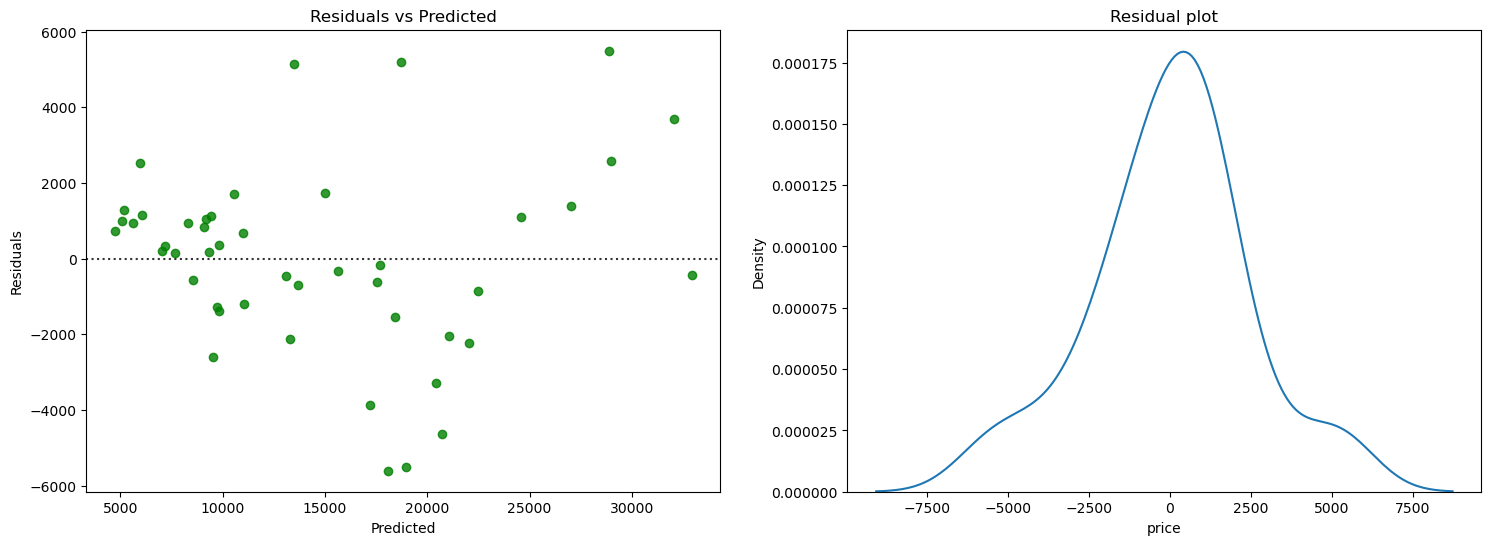

In [7]:
lasso_pipe = Pipeline([
    ('scaler', RobustScaler()),
    ('regressor', Lasso())
])
kf = KFold(n_splits=3)
param_grid = {'regressor__alpha': np.logspace(-3, 3, 100)}

grid_search = GridSearchCV(lasso_pipe, param_grid, cv=kf)
grid_search.fit(X_train, y_train)

best_alpha = grid_search.best_params_['regressor__alpha']

lasso_pipe.set_params(regressor__alpha=best_alpha)
lasso_pipe.fit(X_train, y_train)

cv_scores = cross_val_score(lasso_pipe, X_train, y_train, cv=kf)

predictions = cross_val_predict(lasso_pipe, X_test, y_test, cv=kf)
residuals = y_test - predictions
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')
# Plotting residuals
fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(18, 6))
sns.residplot(x=predictions, y=residuals, color='g', ax=ax1)
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Residuals')
ax1.set_title('Residuals vs Predicted')
sns.kdeplot(residuals, ax=ax2)
ax2.set_title("Residual plot")
plt.show()

# Ridge regression

Mean Absolute Error: 1812.5083204341338
R-squared: 0.9063186946881961


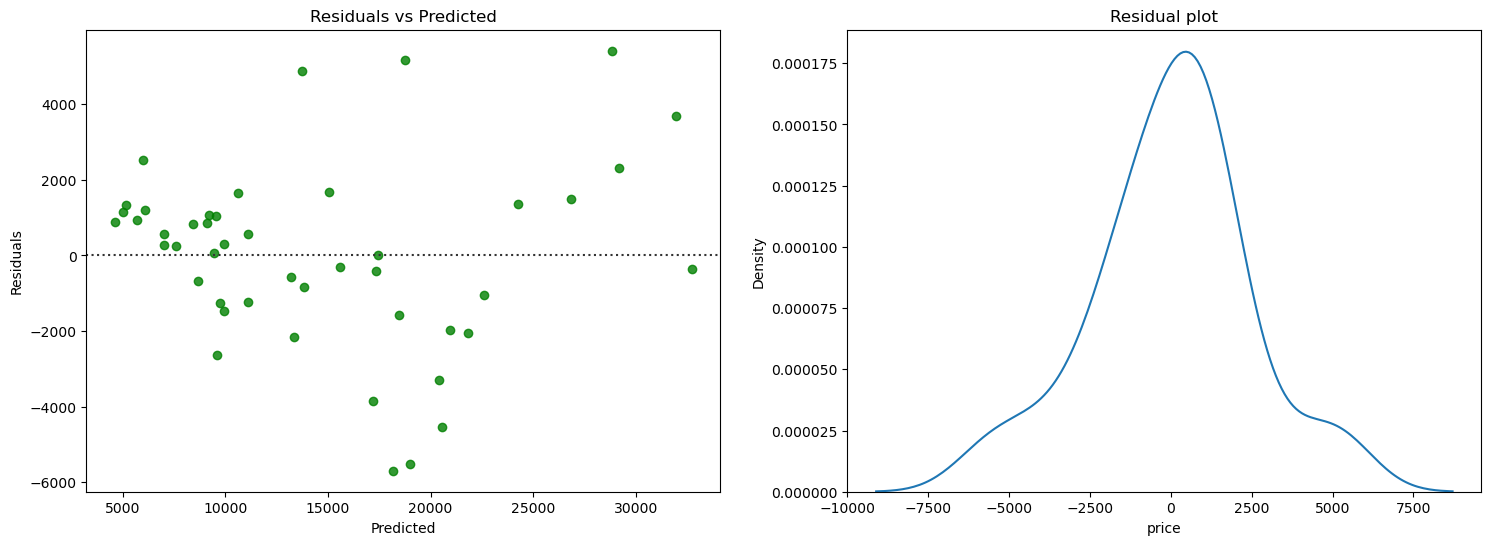

In [8]:
ridge_pipe = Pipeline([
    ('scaler', RobustScaler()),
    ('regressor', Ridge())
])
kf = KFold(n_splits=3)
param_grid = {'regressor__alpha': np.logspace(-3, 3, 100)}

grid_search = GridSearchCV(ridge_pipe, param_grid, cv=kf)
grid_search.fit(X_train, y_train)

best_alpha = grid_search.best_params_['regressor__alpha']

ridge_pipe.set_params(regressor__alpha=best_alpha)
ridge_pipe.fit(X_train, y_train)
cv_scores = cross_val_score(ridge_pipe, X_train, y_train, cv=kf)

predictions = cross_val_predict(ridge_pipe, X_test, y_test, cv=kf)
residuals = y_test - predictions
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')
# Plotting residuals
fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(18, 6))
sns.residplot(x=predictions, y=residuals, color='g', ax=ax1)
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Residuals')
ax1.set_title('Residuals vs Predicted')
sns.kdeplot(residuals, ax=ax2)
ax2.set_title("Residual plot")
plt.show()

# Elastic net regression

Mean Absolute Error: 1810.9945226723762
R-squared: 0.9059361275039375


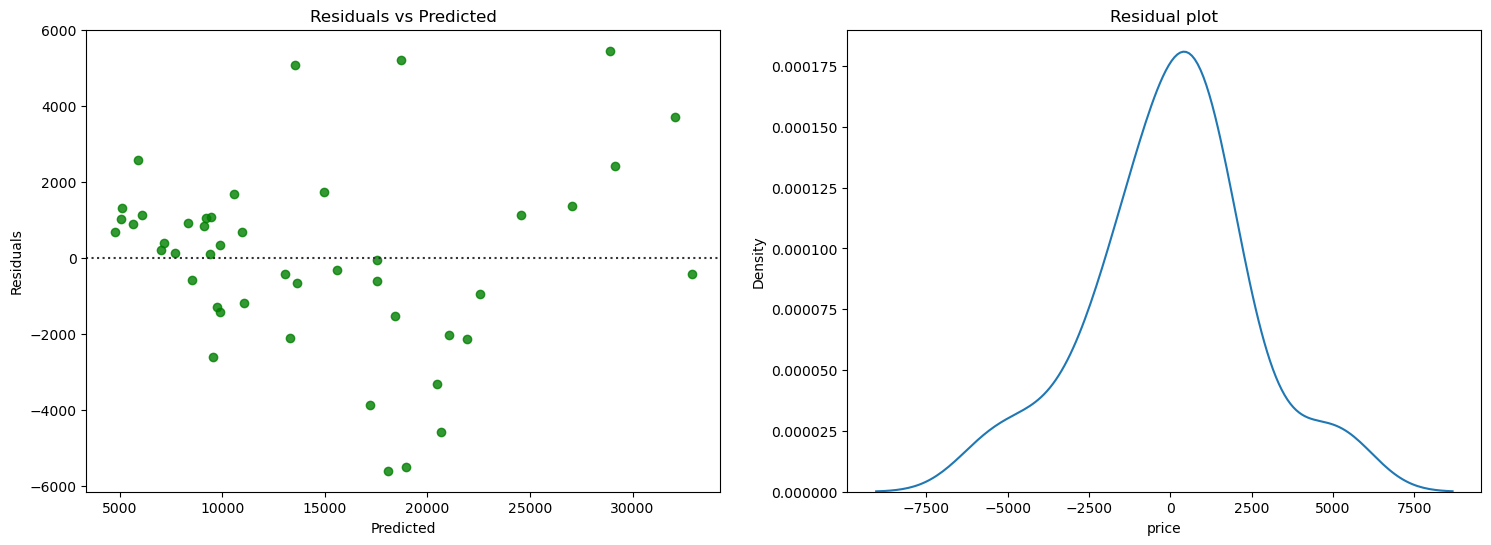

In [9]:
from sklearn.linear_model import ElasticNet

elastic_pipe = Pipeline([
    ('scaler', RobustScaler()),
    ('regressor', ElasticNet())
])

kf = KFold(n_splits=3)
param_grid = {'regressor__alpha': np.logspace(-3, 3, 100),
              'regressor__l1_ratio': np.arange(0.2,0.8,0.1)}
grid_search = GridSearchCV(elastic_pipe, param_grid, cv=kf)
grid_search.fit(X_train, y_train)

best_alpha = grid_search.best_params_['regressor__alpha']
best_l1_ratio = grid_search.best_params_['regressor__l1_ratio']
elastic_pipe.set_params(regressor__alpha=best_alpha)
elastic_pipe.set_params(regressor__l1_ratio=best_l1_ratio)
elastic_pipe.fit(X_train, y_train)
cv_scores = cross_val_score(elastic_pipe, X_train, y_train, cv=kf)

predictions = cross_val_predict(elastic_pipe, X_test, y_test, cv=kf)
residuals = y_test - predictions
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

# Plotting residuals

fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(18, 6))
sns.residplot(x=predictions, y=residuals, color='g', ax=ax1)
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Residuals')
ax1.set_title('Residuals vs Predicted')
sns.kdeplot(residuals, ax=ax2)
ax2.set_title("Residual plot")
plt.show()

# All works nearly same

In [15]:
def avg_lasso(X,y,num_iterations=100):
    lasso_errors=[]
    lasso_scores=[]
    for i in range(num_iterations):
        X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=100+i)
        kf = KFold(n_splits=3,shuffle=True,random_state=100+i)
        param_grid = {'regressor__alpha': np.logspace(-3, 3, 100)}

        grid_search = GridSearchCV(lasso_pipe, param_grid, cv=kf,n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_alpha = grid_search.best_params_['regressor__alpha']
        lasso_pipe.set_params(regressor__alpha=best_alpha)
        lasso_pipe.fit(X_train, y_train)

        predictions = cross_val_predict(lasso_pipe, X_test, y_test, cv=kf)
        mae = mean_absolute_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)
        lasso_errors.append(mae)
        lasso_scores.append(r2)
    return lasso_scores,np.mean(lasso_errors),np.median(lasso_errors),np.mean(lasso_scores),np.median(lasso_scores)
def avg_ridge(X,y,num_iterations=100):
    ridge_errors=[]
    ridge_scores=[]
    for i in range(num_iterations):
        X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=100+i)
        kf = KFold(n_splits=3,shuffle=True,random_state=100+i)
        param_grid = {'regressor__alpha': np.logspace(-3, 3, 100)}

        grid_search = GridSearchCV(ridge_pipe, param_grid, cv=kf,n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_alpha = grid_search.best_params_['regressor__alpha']
        ridge_pipe.set_params(regressor__alpha=best_alpha)
        ridge_pipe.fit(X_train, y_train)

        predictions = cross_val_predict(ridge_pipe, X_test, y_test, cv=kf)
        mae = mean_absolute_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)
        ridge_errors.append(mae)
        ridge_scores.append(r2)
    return ridge_scores,np.mean(ridge_errors),np.median(ridge_errors),np.mean(ridge_scores),np.median(ridge_scores)
def avg_elastic(X,y,num_iterations=100):
    elastic_errors=[]
    elastic_scores=[]
    for i in range(num_iterations):
        X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=100+i)
        kf = KFold(n_splits=3,shuffle=True,random_state=100+i)
        param_grid = {'regressor__alpha': np.logspace(-3, 3, 100),
                        'regressor__l1_ratio': np.arange(0.2,0.8,0.1)}
        grid_search = GridSearchCV(elastic_pipe, param_grid, cv=kf,n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_alpha = grid_search.best_params_['regressor__alpha']
        best_l1_ratio = grid_search.best_params_['regressor__l1_ratio']
        elastic_pipe.set_params(regressor__alpha=best_alpha)
        elastic_pipe.set_params(regressor__l1_ratio=best_l1_ratio)
        elastic_pipe.fit(X_train, y_train)

        predictions = cross_val_predict(elastic_pipe, X_test, y_test, cv=kf)
        mae = mean_absolute_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)
        elastic_errors.append(mae)
        elastic_scores.append(r2)
    return elastic_scores,np.mean(elastic_errors),np.median(elastic_errors),np.mean(elastic_scores),np.median(elastic_scores)

In [18]:
elastic_scores,elastic_mae_mean, elastic_mae_median, elastic_r2_mean, elastic_r2_median = avg_elastic(X, y)
lasso_scores,lasso_mae_mean, lasso_mae_median, lasso_r2_mean, lasso_r2_median = avg_lasso(X, y)
ridge_scores,ridge_mae_mean, ridge_mae_median, ridge_r2_mean, ridge_r2_median = avg_ridge(X, y)

print(f'Mean Absolute lasso Error: {lasso_mae_mean} Mean Absolute ridge Error: {ridge_mae_mean} Mean Absolute Elasticnet Error: {elastic_mae_mean}')
print(f'Median Absolute lasso Error: {lasso_mae_median} Median Absolute ridge Error: {ridge_mae_median} Median Absolute Elasticnet Error: {elastic_mae_median}')
print(f'Avg Mean lasso R-squared: {lasso_r2_mean} Avg Mean ridge R-squared: {ridge_r2_mean} Average Mean Elasticnet R-squared: {elastic_r2_mean}')
print(f'Avg Median lasso R-squared: {lasso_r2_median} Avg Median ridge R-squared: {ridge_r2_median} Avg Median Elasticnet R-squared:{elastic_r2_median}')

Mean Absolute lasso Error: 1819.6447227933832 Mean Absolute ridge Error: 1824.5464738889204 Mean Absolute Elasticnet Error: 1813.3302563650973
Median Absolute lasso Error: 1830.7564945713796 Median Absolute ridge Error: 1832.8137904345658 Median Absolute Elasticnet Error: 1806.9383236402614
Avg Mean lasso R-squared: 0.821943735743752 Avg Mean ridge R-squared: 0.8228139494235127 Average Mean Elasticnet R-squared: 0.8244067254986591
Avg Median lasso R-squared: 0.8393213390909231 Avg Median ridge R-squared: 0.8403941604715357 Avg Median Elasticnet R-squared:0.8414743593239744


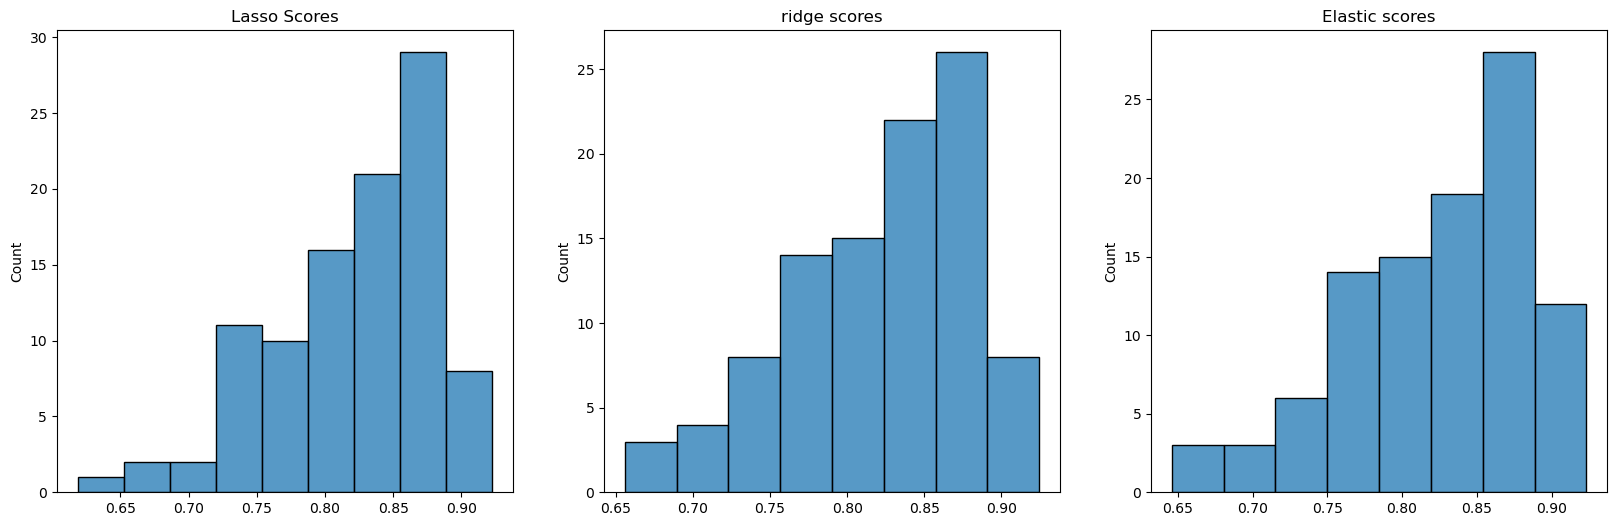

In [17]:
fig, [ax1, ax2, ax3] = plt.subplots(ncols=3, figsize=(20, 6))
sns.histplot(lasso_scores, ax=ax1)
ax1.set_title('Lasso Scores')
sns.histplot(ridge_scores, ax=ax2)
ax2.set_title("ridge scores")
sns.histplot(elastic_scores, ax=ax3)
ax3.set_title("Elastic scores")
plt.show()

# Elastic performs shows better variance of the data than lasso,ridge little bit

# Started absolute error : 4182
# End absolute error : 1813

### We still have some HeteroSkedacity due to nature of data (low scatter at low price and more at high price) ,we could cover those variance using some other regression techniques

### We still have Multicollinearity in the data